# Running gridded DBPM run
**Author**: Denisse Fierro Arcos  
**Date**: 2024-11-01

In [1]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')
from glob import glob
import xarray as xr
import useful_functions as uf
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1)

2025-01-13 15:25:09,761 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('original-open_dataset-size_bins-72c7f0fba951651fb99d2c971bf417b8', 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('original-open_dataset-size_bins-72c7f0fba951651fb99d2c971bf417b8', 0) _execute_subgraph(...)>
new run_spec: <Task ('original-open_dataset-size_bins-72c7f0fba951651fb99d2c971bf417b8', 0) _execute_subgraph(...)>
old token: '362a2827097e72747b479dab2e477614'
new token: '2a06d6e4001fc62ec8acd727236b2a4c'
old dependencies: set()
new dependencies: set()

2025-01-13 15:25:40,561 - distributed.scheduler - WARN

## Loading DBPM parameters 

In [2]:
base_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded_params/'

In [3]:
depth = xr.open_zarr(
     glob(os.path.join('/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
                      '*obsclim_deptho_*'))[0])['deptho']
log10_size_bins_mat = xr.open_zarr('outputs/log10_size_bins_matrix.zarr/')['size_bins']

In [4]:
effort = xr.open_zarr(
    glob(os.path.join(base_folder, 
                      'effort_spinup*'))[0])['effort']
   
predators = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'predators_spinup*1840*'))[0])['predators'] 

detritivores = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'detritivores_*'))[0])['detritivores']

detritus = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'detritus_*'))[0])['detritus']

pel_tempeffect = xr.open_zarr(glob(
    os.path.join(base_folder, 'pel-temp-eff_spinup*'))[0])['pel_temp_eff']

ben_tempeffect = xr.open_zarr(glob(
    os.path.join(base_folder, 'ben-temp-eff_spinup*'))[0])['ben_temp_eff']

In [ ]:
sinking_rate = xr.open_zarr(
    glob(os.path.join('/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
                      '*_spinup_er_*'))[0])['export_ratio']

# Matching years in sinking rate to predator years
ymin = str(predators.time.dt.year.min().values)
ymax = str(predators.time.dt.year.max().values)

sinking_rate = sinking_rate.sel(time = slice(ymin, ymax))

In [7]:
out_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/run_fishing'
os.makedirs(out_folder, exist_ok = True)

In [ ]:
uf.gridded_sizemodel(base_folder, predators, detritivores, detritus, pel_tempeffect, 
                     ben_tempeffect, effort, sinking_rate, depth, log10_size_bins_mat,
                     region = 'fao-58', out_folder = out_folder)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/hh5/public/apps/minico

In [8]:
pred_short = predators.isel(time = 0)
region = 'fao-58'

In [9]:
import json
#Gridded parameters
gridded_params = json.load(open(
    glob(os.path.join(base_folder, 'dbpm_gridded_*_python.json'))[0]))

In [10]:
import numpy as np
log10_size_bins = np.array(gridded_params['log10_size_bins'])
size_bin_vals = 10**log10_size_bins_mat
log_size_increase = gridded_params['log_size_increase']
ind_min_pred_size = gridded_params['ind_min_pred_size']
ind_min_detritivore_size = gridded_params['ind_min_detritivore_size']

In [11]:
pref_benthos = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'pref-benthos_*'))[0])['pref_benthos']

pref_pelagic = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'pref-pelagic_*'))[0])['pref_pelagic']

In [12]:
# Senescence mortality rate to limit large fish from building up in the
# system. Same function as in Law et al 2008. Using chosen parameters
# below gives similar M2 values as in Hall et al. 2006 (SM.u, SM.v)
senes_mort_det = (gridded_params['const_senescence_mort']*
                  10**(gridded_params['exp_senescence_mort']*
                       (log10_size_bins_mat-
                        gridded_params['size_senescence'])))
senes_mort_pred = (gridded_params['const_senescence_mort']*
                   10**(gridded_params['exp_senescence_mort']*
                        (log10_size_bins_mat-
                         gridded_params['size_senescence'])))

In [13]:
size_bin_multi = size_bin_vals*log_size_increase
ts_size_inc = gridded_params['timesteps_years']/log_size_increase

#To be applied to feeding rates for pelagics and benthic groups
feed_mult_pel = (gridded_params['hr_volume_search']*
                 (10**(log10_size_bins_mat*
                       gridded_params['metabolic_req_pred']))*
                 pref_pelagic)

feed_mult_ben = (gridded_params['hr_volume_search']*
                 (10**(log10_size_bins_mat*
                       gridded_params['metabolic_req_pred']))*
                pref_benthos)

In [14]:
constant_growth = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'const-growth_*'))[0])['constant_growth']

constant_mortality = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'const-mort_*'))[0])['constant_mortality']

In [15]:
consume_pelagic = xr.open_zarr(glob(
    os.path.join(base_folder, 
                 'consume-pelagic_*'))[0])['consume_pelagic']

consume_benthos = xr.open_zarr(glob(
    os.path.join(base_folder,
                 'consume-benthos_*'))[0])['consume_benthos']

In [16]:
other_mort_det = (gridded_params['natural_mort']*
                  10**(-0.25*log10_size_bins_mat))
other_mort_pred = (gridded_params['natural_mort']*
                   10**(-0.25*log10_size_bins_mat))

In [17]:
fish_mort_pred = xr.open_zarr(glob(
    os.path.join(base_folder,
                 'fish-mort-pred_*'))[0])['fish_mort_pred']

fish_mort_det = xr.open_zarr(glob(
    os.path.join(base_folder,
                 'fish-mort-det_*'))[0])['fish_mort_det']

In [18]:
i = 0

In [19]:
fishing_mort_pred = fish_mort_pred*effort.isel(time = i+1)
fishing_mort_det = fish_mort_det*effort.isel(time = i+1)

In [20]:
pred_growth = (((pred_short*log_size_increase).
                       dot(constant_growth).
                       rename({'sc': 'size_class'}))*feed_mult_pel)
feed_rate_pel = (pel_tempeffect.isel(time = i)*
                 (pred_growth/
                  (1+gridded_params['handling']*pred_growth)))

In [21]:
detrit_growth = ((detritivores*log_size_increase).
                 dot(constant_growth).
                 rename({'sc': 'size_class'}))*feed_mult_ben
feed_rate_bent = (pel_tempeffect.isel(time = i)*
                  (detrit_growth/(1+gridded_params['handling']*
                                  detrit_growth)))
del detrit_growth

In [22]:
detritus_multiplier = ((1/size_bin_vals)*
                       gridded_params['hr_vol_filter_benthos']*
                       10**(log10_size_bins_mat*
                            gridded_params['metabolic_req_detritivore'])*
                       detritus)
feed_rate_det = (ben_tempeffect.isel(time = i)*
                 detritus_multiplier/
                 (1+gridded_params['handling']*
                  detritus_multiplier))
del detritus_multiplier

In [23]:
growth_int_pred = (gridded_params['growth_prop']*
                   gridded_params['growth_pred']*
                   feed_rate_pel+gridded_params['high_prop']*
                   gridded_params['growth_detritivore']*
                   feed_rate_bent)

# Reproduction (R_u)
if gridded_params['dynamic_reproduction']:
    reprod_pred = (gridded_params['growth_prop']*
                   (1-(gridded_params['growth_pred']+
                       gridded_params['energy_pred']))*
                   feed_rate_pel+
                   gridded_params['growth_prop']*
                   (1-(gridded_params['growth_detritivore']+
                       gridded_params['energy_detritivore']))*
                   feed_rate_bent)
    reprod_pred = (reprod_pred.
                   isel(size_class = slice(ind_min_pred_size+1,
                                   None)))

In [24]:
sat_pel = xr.where(feed_rate_pel > 0, 
                   feed_rate_pel/pred_growth, 0)
del pred_growth

# Predation mortality
# Predators (PM.u)
pred_mort_pred = (consume_pelagic*
                  ((pred_short*sat_pel*log_size_increase).
                   dot(constant_mortality)).
                  rename({'sc': 'size_class'}))
del sat_pel

# Total mortality
# Predators (Z.u)
tot_mort_pred = (pred_mort_pred+pel_tempeffect.isel(time = i)*
                 other_mort_pred+senes_mort_pred+
                 fishing_mort_pred).drop_vars('time')

In [25]:
pred_mort_pred = pred_mort_pred.expand_dims({'time': [pred_short.time.values]})
pred_mort_pred.name = 'pred_mort_pred'
[yr] = pred_mort_pred.time.dt.year.values
[mth] = pred_mort_pred.time.dt.month.values
mth = "{:02d}".format(mth)
# Creating file name
fn = f'pred_mort_pred_15arcmin_{region}_{yr}-{mth}.nc'
del pred_mort_pred, yr, mth, fn

In [26]:
growth_int_det = (gridded_params['high_prop']*
                  gridded_params['growth_detritus']*
                  feed_rate_det)
# Reproduction (R_v)
if gridded_params['dynamic_reproduction']:
    reprod_det = (gridded_params['high_prop']*
                  (1-(gridded_params['growth_detritus']+
                      gridded_params['energy_detritivore']))*
                  feed_rate_det)
    reprod_det = (reprod_det.
                  isel(size_class = slice(ind_min_detritivore_size+1,
                                          None))).drop_vars('time')

In [27]:
calc_growth = ((gridded_params['hr_volume_search']*
                (10**(log10_size_bins_mat*
                      gridded_params['metabolic_req_detritivore']))*
                pref_benthos)*
               ((detritivores*log_size_increase).
                dot(constant_growth)).
               rename({'sc': 'size_class'}))
sat_ben = xr.where(feed_rate_bent > 0, 
                   feed_rate_bent/calc_growth, 0)
del calc_growth

In [28]:
pred_mort_det = xr.where(sat_ben > 0, 
                         (consume_benthos*
                          ((pred_short*sat_ben*log_size_increase).
                           dot(constant_mortality)).
                          rename({'sc': 'size_class'})), 0)

In [43]:
test = ((pred_short.isel(size_class = ind_min_pred_size)+
                         ((reprod_pred*size_bin_multi*
                           pred_short).sum('size_class')*
                          gridded_params['timesteps_years'])/
                         size_bin_multi.isel(size_class = ind_min_pred_size)-
                         ts_size_inc*(1/np.log(10))*
                         (growth_int_pred.
                          isel(size_class = ind_min_pred_size))*
                         pred_short.isel(size_class = ind_min_pred_size)-
                         gridded_params['timesteps_years']*
                         tot_mort_pred.isel(size_class = ind_min_pred_size)*
                         pred_short.isel(size_class = ind_min_pred_size)).
                        drop_vars(('time', 'size_class'))).squeeze('time')

In [44]:
# test['time'] = predators.time[1].values
test#.squeeze('time')

<xarray.DataArray (lat: 106, lon: 480)> Size: 407kB
dask.array<getitem, shape=(106, 480), dtype=float64, chunksize=(27, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 848B -45.12 -45.38 -45.62 ... -70.88 -71.12 -71.38
  * lon      (lon) float64 4kB 30.12 30.38 30.62 30.88 ... 149.4 149.6 149.9

In [45]:
xr.where(
        (predators.size_class == 
         gridded_params['log10_ind_min_pred_size']) &
        (predators.time == predators.time[i+1]), test, 
        predators)

<xarray.DataArray (size_class: 181, time: 109, lat: 106, lon: 480)> Size: 8GB
dask.array<where, shape=(181, 109, 106, 480), dtype=float64, chunksize=(181, 109, 27, 120), chunktype=numpy.ndarray>
Coordinates:
  * size_class  (size_class) float64 1kB -12.0 -11.9 -11.8 -11.7 ... 5.8 5.9 6.0
  * time        (time) datetime64[ns] 872B 1840-12-31T23:59:00 ... 1849-12-01
  * lat         (lat) float64 848B -45.12 -45.38 -45.62 ... -70.88 -71.12 -71.38
  * lon         (lon) float64 4kB 30.12 30.38 30.62 30.88 ... 149.4 149.6 149.9

In [106]:
import pandas as pd
test = pd.to_datetime(str(predators.time[1].values)).strftime('%Y-%m-%d')

In [128]:
pred_mort_det['time'] = [predators.time[1].values]
# pred_mort_det.expand_dims({'time': predators.time[1].values})
pred_mort_det.time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['1841-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 1841-01-01

In [131]:
pred_mort_det.time.dt.year.values

array([1841])

In [14]:
predators.keys()

AttributeError: 'DataArray' object has no attribute 'keys'

In [7]:

# from glob import glob
a = xr.open_dataarray('/g/data/vf71/la6889/dbpm_inputs/east_antarctica/test_run/detritivores_15arcmin_fao-58_1961-01.nc')
a
# a = xr.open_mfdataset(sorted(glob(os.path.join(out_folder, 'effo*')))

<xarray.DataArray 'detritivores' (size_class: 181, lat: 46, lon: 40)> Size: 3MB
[333040 values with dtype=float64]
Coordinates:
  * size_class  (size_class) float64 1kB -12.0 -11.9 -11.8 -11.7 ... 5.8 5.9 6.0
  * lat         (lat) float64 368B -60.12 -60.38 -60.62 ... -70.88 -71.12 -71.38
  * lon         (lon) float64 320B 70.12 70.38 70.62 70.88 ... 79.38 79.62 79.88
    time        datetime64[ns] 8B ...

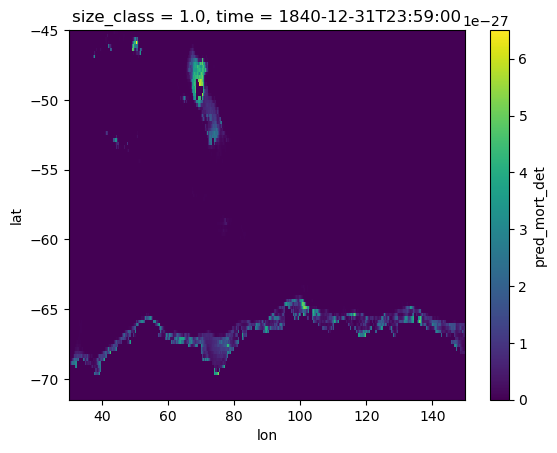

In [52]:
a[...,0, 130].plot()

In [34]:
b = xr.open_mfdataset(sorted(glob(os.path.join(out_folder,
                                               '*predators*'))),
                            combine='nested', concat_dim = 'time')

In [17]:
a= xr.open_zarr('/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded_params/ben-temp-eff_15arcmin_fao-58_monthly_1961_2010.zarr/')
a = a ['ben_temp_eff']

In [36]:
# a.indexes['time'].to_datetimeindex()[0]
b.time

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['1961-01-01T00:00:00.000000000', '1961-02-01T00:00:00.000000000',
       '1961-03-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 1961-01-01 1961-02-01 1961-03-01

In [28]:
b = xr.zeros_like(a[0])
b['time'] = str(a.indexes['time'].to_datetimeindex()[0])
b.time

/jobfs/132222511.gadi-pbs/ipykernel_1560886/3365293635.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  b['time'] = str(a.indexes['time'].to_datetimeindex()[0])


<xarray.DataArray 'time' ()> Size: 76B
array('1961-01-01 00:00:00', dtype='<U19')
Coordinates:
    time     <U19 76B '1961-01-01 00:00:00'

In [27]:
str(a.indexes['time'].to_datetimeindex()[0])

/jobfs/132222511.gadi-pbs/ipykernel_1560886/458749048.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  str(a.indexes['time'].to_datetimeindex()[0])


'1961-01-01 00:00:00'

In [30]:
sinking_rate.isel(time = 0).time

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.Datetime360Day(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 8B 1961-01-01 00:00:00

## Outside time loop

### Fisheries catches per year per size class
`fishing_mort_pred` and `fishing_mort_det` are set to zero outside the sizes for each class, so there is no need to apply a mask here.

In [356]:
catch_pred = fishing_mort_pred*predators*size_bin_vals
catch_det = fishing_mort_det*detritivores*size_bin_vals